In [48]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import os
warnings.filterwarnings('ignore')
# %matplotlib inline


In [49]:

# reading the file

data = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/Mike1310_save_averagetemp_with_GBGdata.csv')
data['Datum'] = pd.to_datetime(data['Datum'])
data = data.set_index('Datum')
data = data.asfreq('D')
data['Month']= data.index.month

data
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
snitt_temp = data['Snittemperatur'].mean()
data['Snittemperatur'] = data['Snittemperatur'].fillna(snitt_temp)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data['Year'].value_counts().sort_values(ascending=False)

Number of rows with missing values: 0.0010331645831180907
Number of rows with missing values: 0.0


Year
1944    366
1980    366
1960    366
1948    366
1952    366
       ... 
2019    365
1946    365
2021    365
2022    365
2023    182
Name: count, Length: 80, dtype: int64

In [50]:
year_avg = pd.pivot_table(data, values = 'Snittemperatur', index = 'Year', aggfunc='mean')

year_avg['10 Years MA'] = year_avg['Snittemperatur'].rolling(10).mean()

year_avg

,Snittemperatur,10 Years MA
Year,,
1944,8.546812,NaN
1945,8.659178,NaN
1946,7.941918,NaN
1947,7.304018,NaN
1948,8.419672,NaN
...,...,...
2019,9.855479,9.125969
2020,10.587732,9.521175
2021,9.023589,9.490213


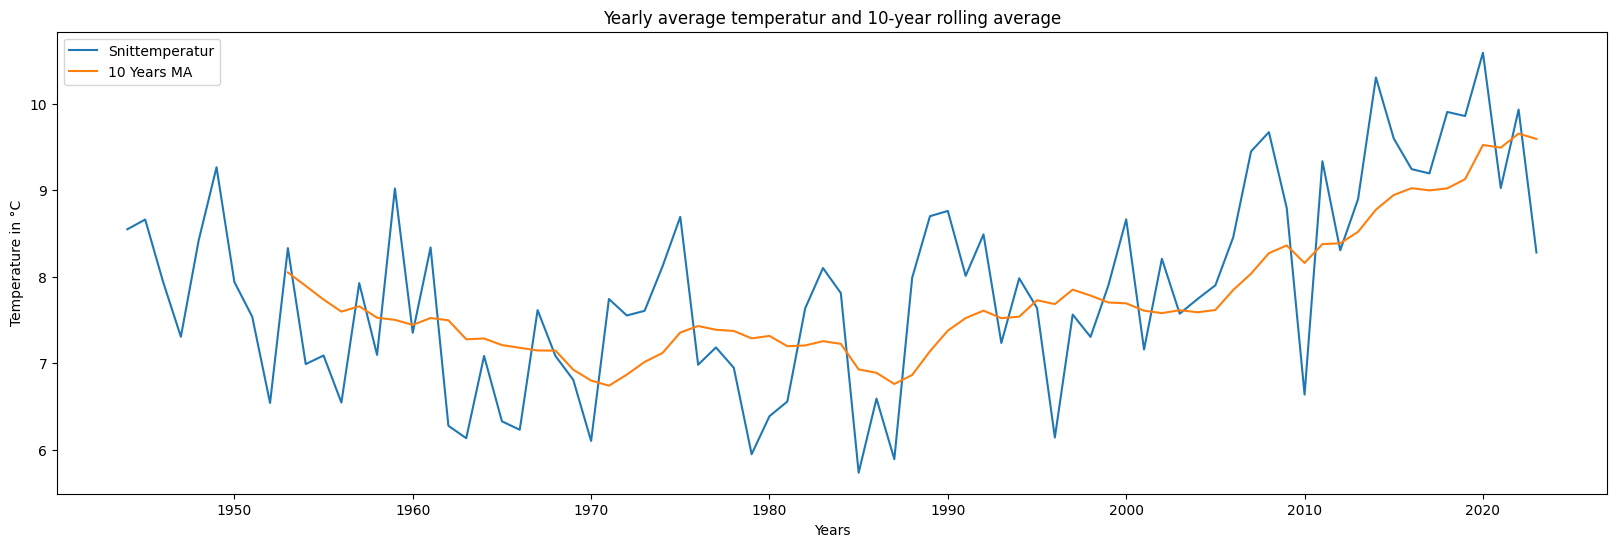

In [51]:
year_avg[['Snittemperatur', '10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly average temperatur and 10-year rolling average')
plt.xlabel('Years')
plt.ylabel('Temperature in °C')
plt.show()

Train dates : 1944-01-01 00:00:00 --- 2009-12-31 00:00:00  (n=24107)
Test dates  : 2010-01-01 00:00:00 --- 2023-07-01 00:00:00  (n=4930)


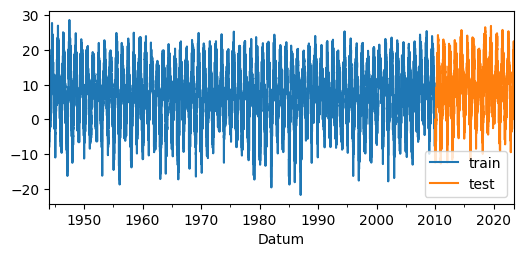

In [52]:
# split training and test data, with cut off at year, 2010

cutoff_date = '2010-01-01'
data_train = data[data.index < cutoff_date]
data_test = data[data.index >= cutoff_date]


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train['Snittemperatur'].plot(ax=ax, label='train')
data_test['Snittemperatur'].plot(ax=ax, label='test')
ax.legend()
plt.show()


In [46]:

# data_train['Year'] = pd.to_datetime(data_train['Year'])
# data_test['Year'] = pd.to_datetime(data_test['Year'])

# data_train['Month'] = pd.to_datetime(data_train['Month'])
# data_test['Month'] = pd.to_datetime(data_test['Month'])
# data_train.dtypes




Snittemperatur           float64
Year              datetime64[ns]
Month             datetime64[ns]
dtype: object

In [53]:
data_train

,Snittemperatur,Year,Month
Datum,,,
1944-01-01,3.200000,1944,1
1944-01-02,3.600000,1944,1
1944-01-03,2.800000,1944,1
1944-01-04,-4.466667,1944,1
1944-01-05,-1.400000,1944,1
...,...,...,...
2009-12-27,1.510000,2009,12
2009-12-28,-0.700000,2009,12
2009-12-29,-2.970000,2009,12


validation set? 

In [ ]:
# check stationarity- if p-value is lower than 5%, the series is stationary and you can create model 
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('Rio de Janeiro Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe serie seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe serie isn't stationary")

In [ ]:
check_stationarity(data_train['Snittemperatur'])
